# Brownian motion

Een van de bekendste voorbeelden van botsende deeltjes in de natuur is Brownian motion.
Fijn gemalen pollen in water lijken te dansen in willekeurige richting.
Dit komt doordat de pollen worden geraakt door watermoleculen die in alle richtingen bewegen.
Omdat de pollen veel zwaarder zijn dan watermoleculen, dus de beweging van de pollen is veel langzamer en minder "intens" dan die van de watermoleculen.
Dit proces van willekeurige beweging door botsingen met kleinere deeltjes wordt Brownian motion genoemd en kunnen we simuleren op basis van ons (premature) botsingsmodel.
Daarbij kunnen we ook gebruik maken van de zojuist geleerde manier van tracking van deeltjes, waarbij we een zowel het zware bolletjes als een enkel deeltje kunnen volgen.

Let op!
We bestuderen hier nog geen thermische effecten, deze opdrachten zijn met name bedoeld om beter te begrijpen hoe het botsingsmodel in elkaar zit.

```{warning}
In dit notebook zitten delen waar ruimte is om code toe te voegen, maar waarbij je denkt... waarom dan?
In een latere opdracht moet je terug naar die cell en de juiste code toevoegen.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Maken van de ParticleClass
class ParticleClass:
    # Het maken van het deeltje
    def __init__(self, m, v, r, R, c):
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = np.array(R, dtype=float)  
        self.c = c

    # Het updaten van de positie, eventueel met zwaartekracht
    def update_position(self):
        self.r += self.v * dt #+ 1/2 * a * dt**2  
              
    # Harde wand
    def boxcollision(self):
        global botsing_teller
        if abs(self.r[0]) + self.R > Box_length: 
            self.v[0] = -self.v[0]                                  # Omdraaien van de snelheid
            self.r[0] = np.sign(self.r[0]) * (Box_length - self.R)  # Zet terug net binnen box
            botsing_teller += 1                 
        if abs(self.r[1]) + self.R > Box_length: 
            self.v[1] = -self.v[1]     
            self.r[1] = np.sign(self.r[1]) * (Box_length - self.R) 
            botsing_teller += 1
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)

In [3]:
# Aanmaken van de randvoorwaarden en initiele condities
Box_size_0 = 10
Box_length_0 = Box_size_0/2
Box_length = Box_length_0     # De grootte van de box kan wijzigen!

# Particles
dt = 0.1
particles = []
N = 40
v_0 = 1

dt = 0.04

# Aanmaken van deeltjes
for i in range(N-1):
    vx = np.random.uniform(-v_0,v_0)
    vy = np.random.choice([-1, 1])*np.sqrt(v_0**2-vx**2)        
    pos = Box_length_0*np.random.uniform(-1,1,2)
    particles.append(ParticleClass(m=1.0, v=[vx, vy], r = pos, R=.5,c='blue')) 

particles.append(ParticleClass(m=20.0, v=[0, 0], r = [0, 0], R=.5,c='red')) 


```{exercise} Brownian motion
:label: ex-brownian-1

Leg uit wat er in de laatste regel van bovenstaande script gebeurt.
Voeg voor deze regel goede metadata toe.
```

```{solution} ex-brownian-1
Het maakt een stilstaand deeltje op coördinaten (0,0) aan met 20 maal de massa van een klein deeltje.
```

Er is een doos vol met deeltjes op willekeurige positie aangemaakt.
We willen kijken waar de deeltjes zijn terechtgekomen.
Hieronder staat dit weergegeven. 



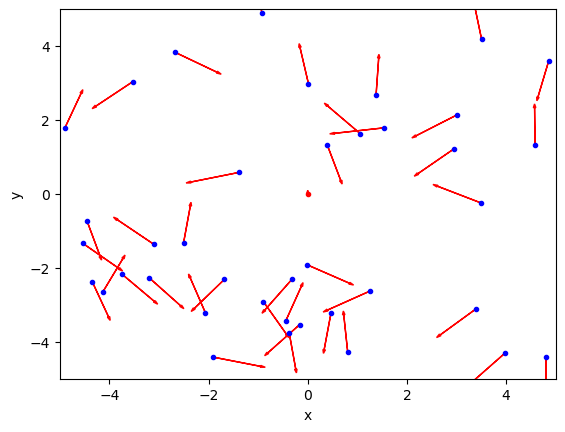

In [4]:
# Inspecteren van beginsituatie
plt.figure()

plt.xlabel('x')
plt.ylabel('y')

plt.xlim(-Box_length_0,Box_length_0)
plt.ylim(-Box_length_0,Box_length_0)


for particle, particle_object in enumerate(particles):
    plt.plot(particle_object.r[0],particle_object.r[1],color=particle_object.c,marker='.')
    plt.arrow(particle_object.r[0],particle_object.r[1], 
               particle_object.v[0],particle_object.v[1], 
               head_width=0.05, head_length=0.1, color='red')
plt.show()


```{exercise} 
:label: ex-brownian-2

Er staat ook code met comments ervoor, wat doet deze code? 
Check je antwoord door de comments weg te halen.
Hoe wordt er voor gezorgd dat de snelheid van elk deeltje gelijk is?
```

```{solution} ex-brownian-2
Het geeft vectors aan de bolletjes, die starten in het bolletje en in de richting van de snelheid wijzen.
De grootte van de snelheidsvector is altijd: $\sqrt(v_x**2+v_y**2)=\sqrt(v_x**2+V_0**2-v_x**2)=V_0$. Dus elk deeltje heeft een snelheid +/- $V_0$.  

```

We gaan nu de functies van de simulatie weer aanroepen:

In [5]:
botsing_teller = 0
aantal_botsingen = np.array([])

# Het bepalen of er een botsing plaats vindt
def collide_detection(self, other):
    dx = self.r[0] - other.r[0]
    dy = self.r[1] - other.r[1]
    rr = self.R + other.R
    return  dx**2+dy**2 < rr**2 
        
def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

    global botsing_teller
    botsing_teller += 1

def handle_collisions(particles):
#your code/answer
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])
#your code/answer


In onderstaande code geven we de code voor de simulatie en volgen we de positie van het zware deeltje. 

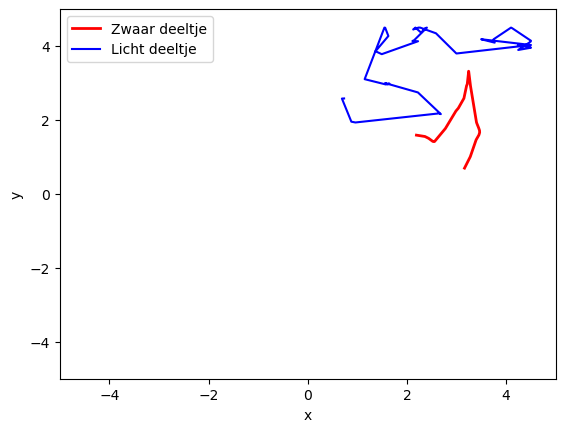

In [12]:
# tracken van het zware deeltje
track_x = []
track_y = []

#tracken van het lichte deeltje
l = 1 #nummer van het getrackte lichte deeltje
track_x_licht = []
track_y_licht = []


#your code/answer

for i in range(400):
#your code/answer
    
    for p in particles:
        p.update_position()    # Update positie        
        p.boxcollision()         # Wandbotsing werkt per deeltje
        
    handle_collisions(particles)
    aantal_botsingen = np.append(aantal_botsingen, botsing_teller)
    botsing_teller = 0 #terugzetten naar 0 voor volgende tijdstap 
    
    track_x.append(particles[N-1].r[0])
    track_y.append(particles[N-1].r[1])
    track_x_licht.append(particles[l].r[0])
    track_y_licht.append(particles[l].r[1])

plt.figure()
plt.xlim(-Box_length_0,Box_length_0)
plt.ylim(-Box_length_0,Box_length_0) 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(track_x,track_y,'r', linewidth = 2, label='Zwaar deeltje')
plt.plot(track_x_licht,track_y_licht,'b', label='Licht deeltje')
plt.legend()
plt.show()

```{exercise} Brownian motion in beeld
:label: ex-brownian-3
- Draai de onderstaande simulatie een keer en bestudeer de output.
- Voeg zelf een tweede tracking toe van een licht deeltje en verbeter de plot.
- Wat zijn overeenkomsten en verschillen tussen de beweging van de twee deeltjes?
- Wat valt je op als je de simulatie een aantal keer runt?
```

```{solution} ex-brownian-3
- Zowel het lichte als zware deeltje veranderen meerdere keren van richting en blijven in het afgebakende gebied. Een verschil is dat het zware deeltje minder vaak en in mindere mate van richting verandert ten opzichte van het lichte deetje. 
- Als de simulatie een aantal keer runt is het nieuwe pad in het verlengde van het vorige weergegeven pad. Het zware deeltje begint dus niet telkens opnieuw op x=0 en y=0, maar gaat verder op het punt waar het deeltje in de vorige simulatie was gebleven. 
```

We zouden gevoel willen krijgen voor het aantal botsingen dat per tijdseenheid plaatsvindt. 
Elke keer dat er een botsing plaatsvindt, zou de counter met 1 omhoog moeten gaan.
Idealiter wordt het aantal botsingen opgeslagen in een array zodat je het aantal botsingen als functie van de tijd kunt weergeven.

```{exercise}
Pas bovenstaand idee toe in de eerder gemaakte code.
Plot hieronder het aantal botsingen als functie van de tijd.
```

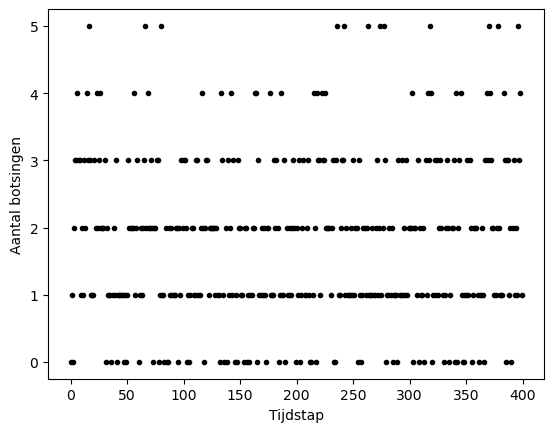

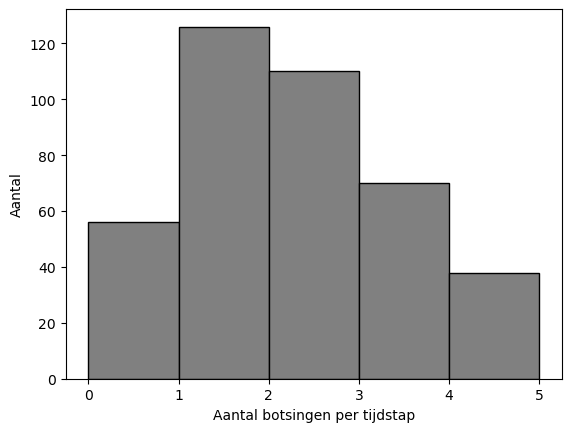

In [ ]:
#Grafiek aantal botsingen per tijdstap
plt.figure()
plt.xlabel('Tijdstap')
plt.ylabel('Aantal botsingen')
plt.plot(range(len(aantal_botsingen)), aantal_botsingen, 'k.')
plt.show()

#Histogram aantal botsingen per tijdstap
plt.figure()
plt.xlabel('Aantal botsingen per tijdstap')
plt.ylabel('Aantal')
plt.hist(aantal_botsingen, bins=[0,1,2,3,4,5], edgecolor='black', color='gray')
plt.show()

```{warning} 🌶 Let op!
:icon: false
De onderstaande opdrachten vallen buiten de stof maar tellen mee als je excellent wilt behalen.
```

In zulke fysica modellen is de afgelegde weg (afstand tussen begin en eindpunt) van belang.
Deze afgelegde weg zegt iets over de snelheid van difussie.
Idealiter bekijken we een histogram.
Maar voor een histogram hebben we veel deeltjes nodig.



```{exercise} Afgelegde weg 🌶
:label: ex-brownian-4

- Maak een simulatie met 361 deeltjes, waarvan 1 zwaar deeltje.
- Houd rekening met de boxgrootte, deze moet mee schalen!
- Maak een histogram van de afgelegde weg voor alle deeltjes. 
- Geef de afgelegde weg van het grote deeltje duidelijk aan.
```


In [ ]:
#your code/answer


En nu we toch bezig zijn met twee verschillende deeltjes.... 

We kunnen twee "groepen" van deeltjes aanmaken, elk  met een andere massa. Als we dan de zwaartekracht aan zetten, dan zouden we verwachten dat de lichtere deeltjes boven komen "drijven".

```{exercise} Onderzoek dit vermoeden 🌶
- maak daartoe de box 2x zo hoog als breed
- verdubbel het totaal aantal deeltjes
- zet een artificieel grote zwaartekracht aan
```

In [ ]:
#your code/answer
